In [128]:
from matplotlib import pyplot as plt
import platform, os, sys, time, h5py
from tqdm import tqdm
import numpy as np

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    sys.path.append(r"C:\Users\Gerwin\Documents\Code\iPythonNotebooks\Scripts")
    save_path = r"S:\Gerwin\Electron on helium\Electron optimization\Realistic potential\Resonator"
else:
    sys.path.append(r"/Users/gkoolstra/Documents/Code/iPythonNotebooks/Scripts")
    sys.path.append("/Users/gkoolstra/Documents/Code")
    save_path = r"/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/Resonator"

from BEMHelper import interpolate_slow
from resonator_eom import *
    
from Common import common, kfit
from TrapAnalysis import import_data, artificial_anneal as anneal


sub_dir = r"170831_200626_M018V6_resonator_Vsweep_150_electrons"

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [129]:
helium_height = 0.8E-6 #1.00 These must match the values used in the simulation
screening_length = 2 * 0.80 * 1E-6
box_y_length = 40E-6

In [130]:
Vres = list()
print("Loading optimization data...")

with h5py.File(os.path.join(os.path.join(save_path, sub_dir), "Results.h5"), "r") as f:
    k = 0
    converged = list()

    for step in tqdm(f.keys()):
        if "step" in step:
            electron_ri = f[step + "/electron_final_coordinates"][()]

            if k == 0:
                electron_positions = electron_ri
            else:
                electron_positions = np.vstack((electron_positions, electron_ri))

            converged.append(f[step + "/solution_converged"][()])
            k += 1

    Vres = f["Vres"][()]

# Load the data from the dsp file:
if 'Windows' in platform.system():
    path = r'S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6\With L3 etch - just trap'
else:
    path = r'/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V6/With L3 etch - just trap'
potential_file = r"ResonatorBiasSymmetricPotential_1100nm.dsp"
efield_file = r"2D Differential Mode Ex.dsp"
elements, nodes, elem_solution, bounding_box = import_data.load_dsp(os.path.join(path, potential_file))

xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
x0 = -2.0  # Starting point for y
k = 151  # This defines the sampling
xeval = anneal.construct_symmetric_y(x0, k)

xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval,
                                                              yeval=helium_height * 1E6, clim=(0.00, 1.00), plot_axes='xy',
                                                              linestyle='None',
                                                              cmap=plt.cm.viridis, plot_data=False,
                                                              **common.plot_opt("darkorange", msize=6))

# Mirror around the y-axis
xsize = len(Uinterp[0])
Uinterp_symmetric = np.zeros(2 * xsize)
Uinterp_symmetric[:xsize] = Uinterp[0]
Uinterp_symmetric[xsize:] = Uinterp[0][::-1]

x_symmetric = np.zeros(2 * xsize)
x_symmetric[:xsize] = xinterp[0]
x_symmetric[xsize:] = -xinterp[0][::-1]

elements, nodes, elem_solution, bounding_box = import_data.load_dsp(os.path.join(path, efield_file))

xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)

xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=x_symmetric,
                                                              yeval=helium_height * 1E6, clim=(-4E5, 4E5), plot_axes='xy',
                                                              linestyle='None',
                                                              cmap=plt.cm.viridis, plot_data=False,
                                                              **common.plot_opt("darkorange", msize=6))

Loading optimization data...


100%|██████████| 202/202 [00:00<00:00, 274.92it/s]


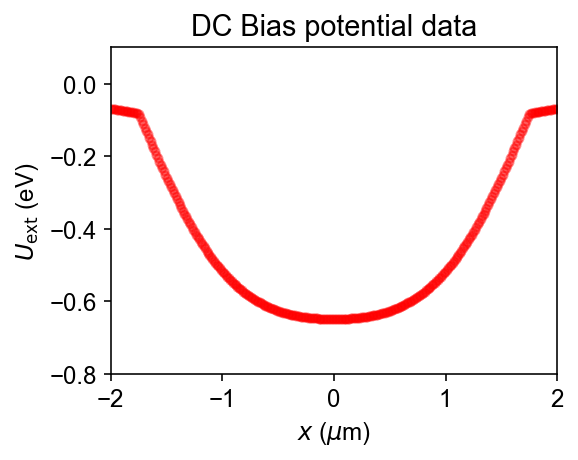

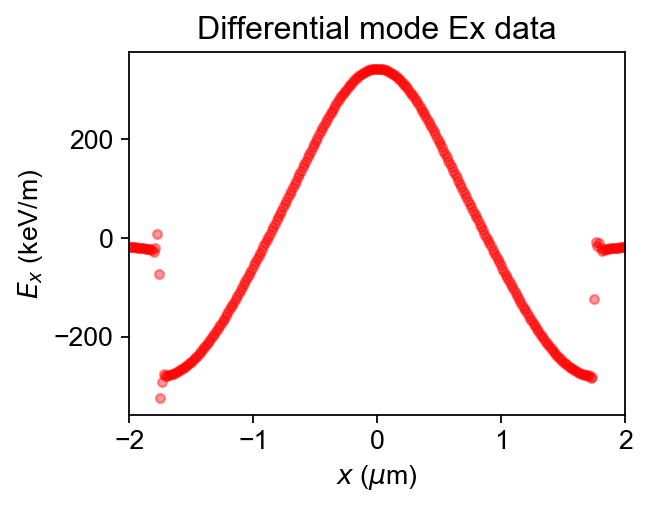

In [131]:
fig1 = plt.figure(figsize=(4., 3.))
common.configure_axes(12)
plt.plot(x_symmetric, -Uinterp_symmetric, 'o', **common.plot_opt('red', msize=4))
plt.ylim(-0.8, 0.1)
plt.xlim(-2, 2)
plt.ylabel("$U_{\mathrm{ext}}$ (eV)")
plt.xlabel("$x$ ($\mu$m)")
plt.title("DC Bias potential data")

fig2 = plt.figure(figsize=(4., 3.))
common.configure_axes(12)
plt.plot(xinterp[0], Uinterp[0]/1E3, 'o', **common.plot_opt('red', msize=4))
# plt.ylim(-0.8, 0.1)
plt.xlim(-2, 2)
plt.ylabel("$E_{x}$ (keV/m)")
plt.xlabel("$x$ ($\mu$m)")
plt.title("Differential mode Ex data")

196it [00:03, 49.05it/s]


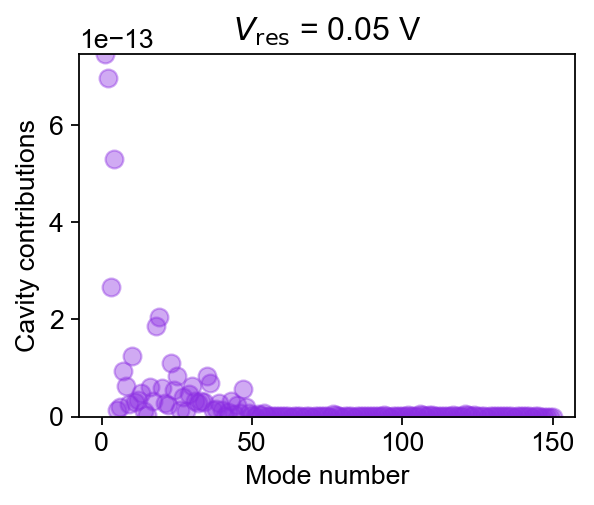

In [132]:
#RS = anneal.ResonatorSolver(x_symmetric * 1E-6, -0.50 * Uinterp_symmetric, efield_data=3E-5 * Uinterp[0])

#plt.figure()
#plt.plot(np.linspace(-2, 2)*1E-6, RS.Ex(np.linspace(-2, 2)*1E-6, 0))


N_electrons = np.int(np.shape(electron_positions)[1] / 2)
cavity_f = list()
electron_f = list()
ten_strongest_mode_numbers = np.zeros((len(Vres), 10), dtype=np.int)
Eigenvalues = np.zeros((len(Vres), N_electrons + 1))
Eigenvectors = np.zeros((N_electrons + 1, N_electrons + 1, len(Vres)))

for k, resV in tqdm(enumerate(Vres)):
    LHS = setup_eom(electron_positions=electron_positions[k, :], Vres=resV, x_symmetric=x_symmetric * 1E-6,
                    Uinterp_symmetric=Uinterp_symmetric, Uinterp=Uinterp,
                    screening_length=screening_length)
    evals, evecs = solve_eom(LHS)

    Eigenvalues[k, :] = evals.flatten()
    Eigenvectors[:, :, k] = evecs

    cavity_contributions = evecs[0, :]
    ranked_cavity_contributions = np.argsort(np.abs(cavity_contributions))

    cavity_mode_idx = ranked_cavity_contributions[-1]
    electron_evs = np.delete(evals, cavity_mode_idx)

    ten_strongest_mode_numbers[k, :] = ranked_cavity_contributions[-10:]

    # Now save the electron mode frequency of the mode that couples second strongest to the cavity
    electron_f.append(np.sqrt(evals[ranked_cavity_contributions[-2]]) / (2 * np.pi * 1E9))
    # And save the cavity mode frequency
    cavity_f.append(np.sqrt(evals[cavity_mode_idx]) / (2 * np.pi))

plt.figure(figsize=(4., 3.))
plt.plot(np.abs(cavity_contributions), 'o', **common.plot_opt('blueviolet'))
plt.ylim(0., cavity_contributions[ten_strongest_mode_numbers[-1, -2]])
plt.xlabel("Mode number")
plt.ylabel("Cavity contributions")
plt.title("$V_\mathrm{res}$ = %.2f V" % Vres[-1])

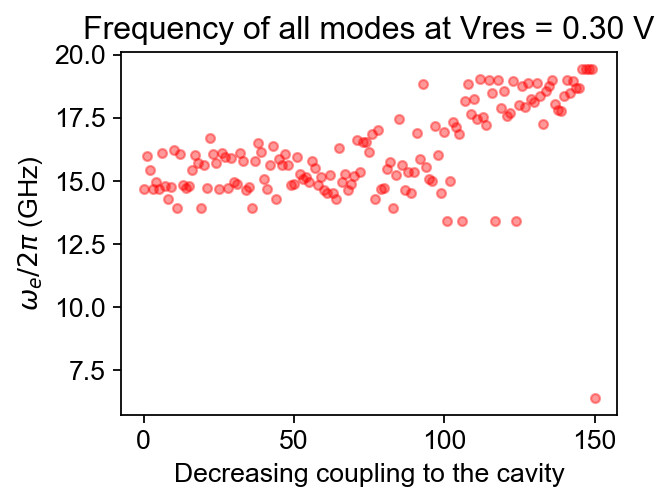

In [133]:
Voi = 0.3
Voi_idx = common.find_nearest(np.array(Vres), Voi)
modes = ten_strongest_mode_numbers[Voi_idx, 1:10]

fig3 = plt.figure(figsize=(4., 3.))
plt.plot(np.sqrt(Eigenvalues[Voi_idx, ranked_cavity_contributions]) / (2 * np.pi * 1E9), 'o', **common.plot_opt('red', msize=4))
plt.xlabel("Decreasing coupling to the cavity")
plt.ylabel("$\omega_e/2\pi$ (GHz)")
plt.title("Frequency of all modes at Vres = %.2f V" % Voi)

# Look at the electron position of the last voltage step and single out the electrons in the left and right row
# Note: this only makes sense if you have two rows!
xi, yi = anneal.r2xy(electron_positions[Voi_idx, :])
right_idxs = np.where(xi > 0)[0]
sorted_right_idxs = np.argsort(right_idxs)
left_idxs = np.where(xi < 0)[0]
sorted_left_idxs = np.argsort(left_idxs)
sorted_idxs = np.argsort(yi)

if len(right_idxs) == 0 or len(left_idxs) == 0:
    print("2 row configuration not detected, assuming 1 row")
    two_rows = False
else:
    two_rows = False
    # two_rows = True

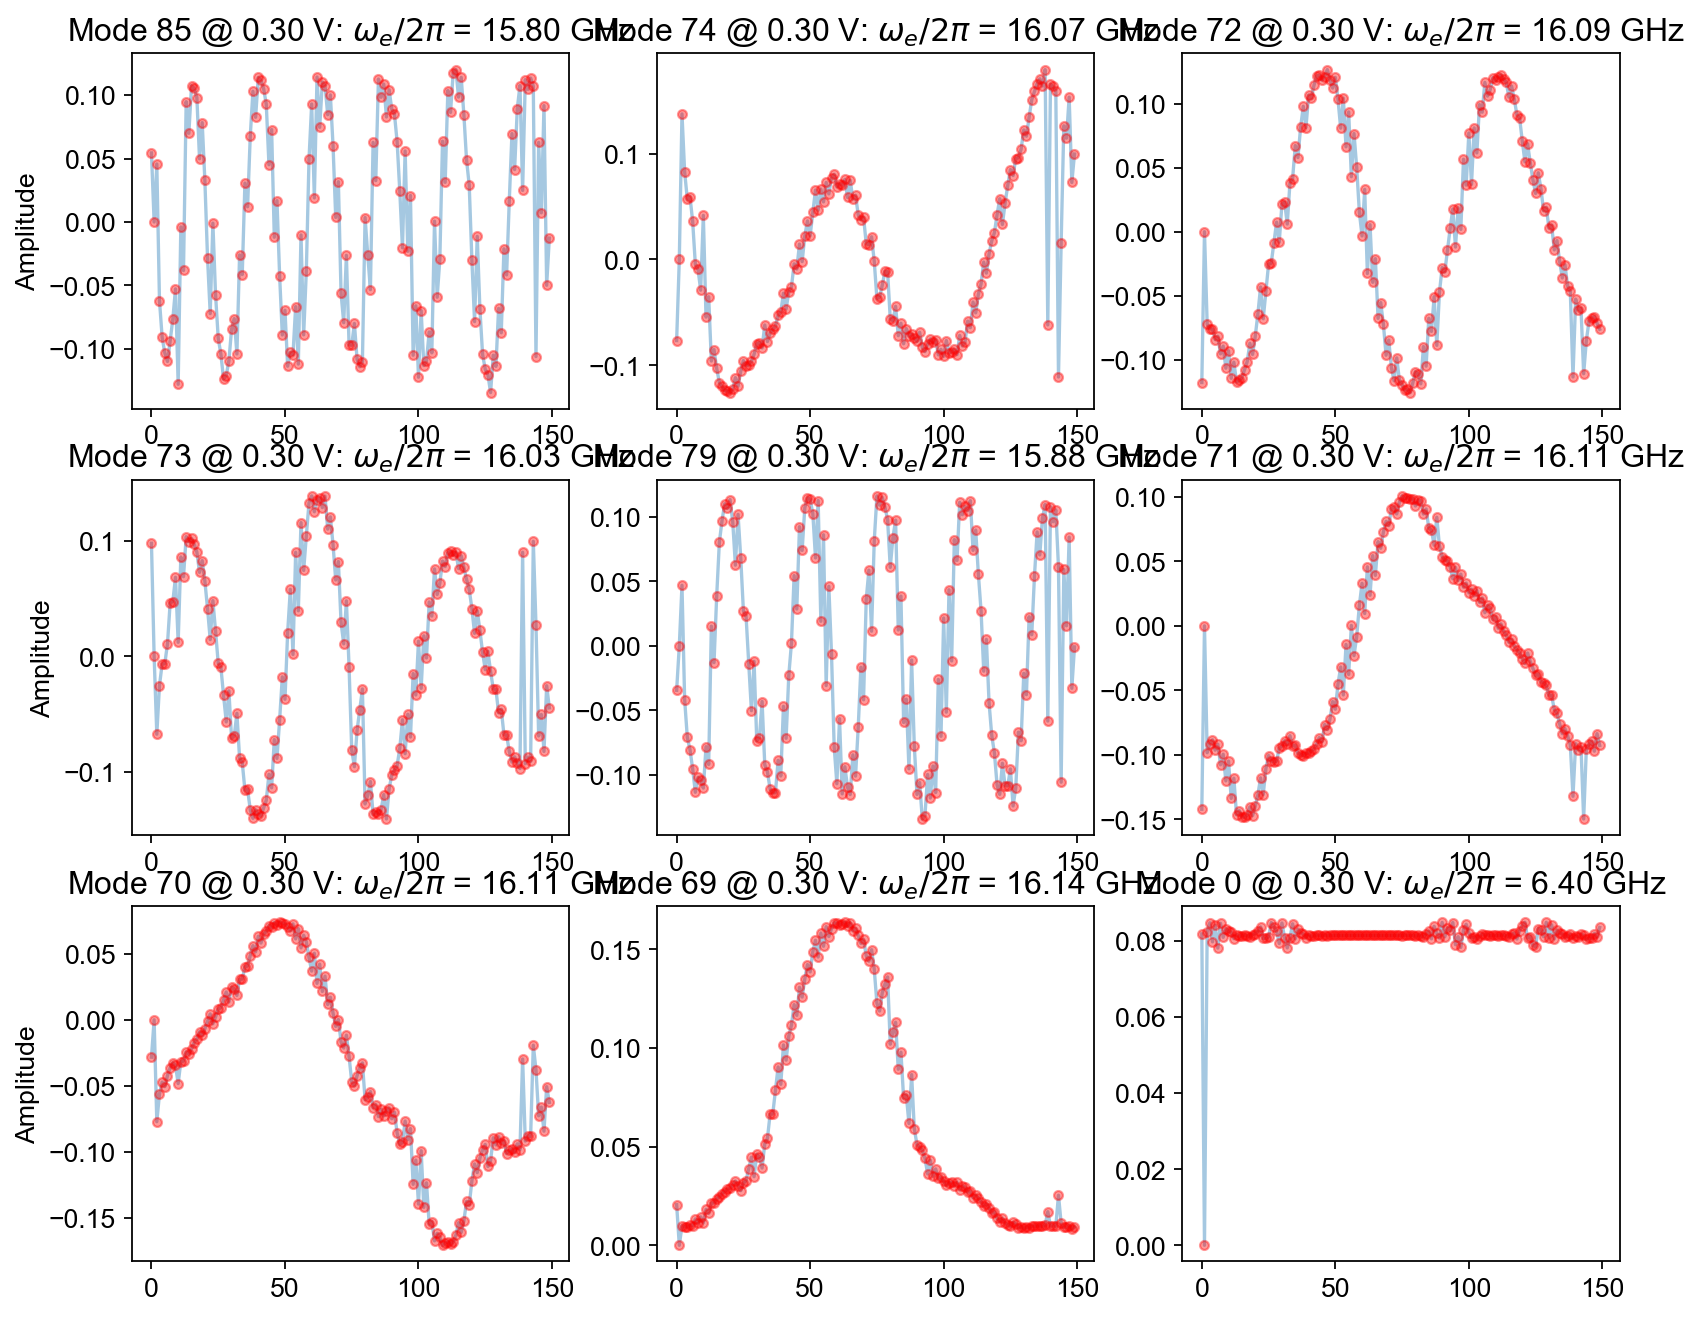

In [134]:
# Here we create a plot with the amplitude of the electrons in the chain (from bottom to top) for the first
# 9 strongest eigenmodes. The last subplot shows the mode that couples strongest.
fig4 = plt.figure(figsize=(12., 10.))
for i, m in enumerate(modes):
    plt.subplot(3, 3, i + 1)

    if two_rows:
        plt.plot(Eigenvectors[sorted_right_idxs, m, Voi_idx], '-o', label="Right row",
                 **common.plot_opt("black", msize=5))
        plt.plot(Eigenvectors[sorted_left_idxs, m, Voi_idx], '-o', label="Left row",
                 **common.plot_opt("red", msize=4))
    else:
        plt.plot(Eigenvectors[sorted_idxs, m, Voi_idx], '-o', **common.plot_opt("red", msize=4))

    if not i % 3:
        plt.ylabel("Amplitude")
    if i > 9:
        plt.xlabel("Position along the row")

    plt.title(u"Mode {0:d} @ {1:.2f} V: $\omega_e/2\pi$ = {2:.2f} GHz" \
              .format(m, Voi, np.sqrt(Eigenvalues[Voi_idx, m]) / (2 * np.pi * 1E9)))
    if two_rows:
        plt.legend(loc=0, prop={'size': 10})

The resonator is 4500 um long, which is 112.5 box lengths
On the resonator there are 16874 electrons


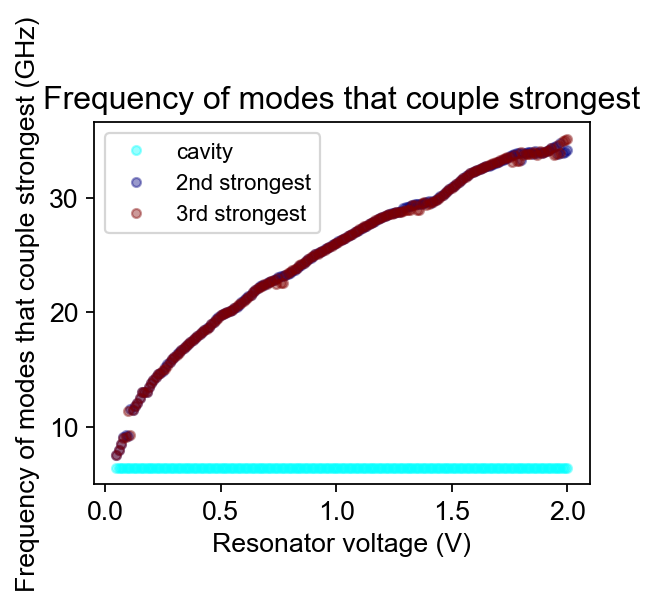

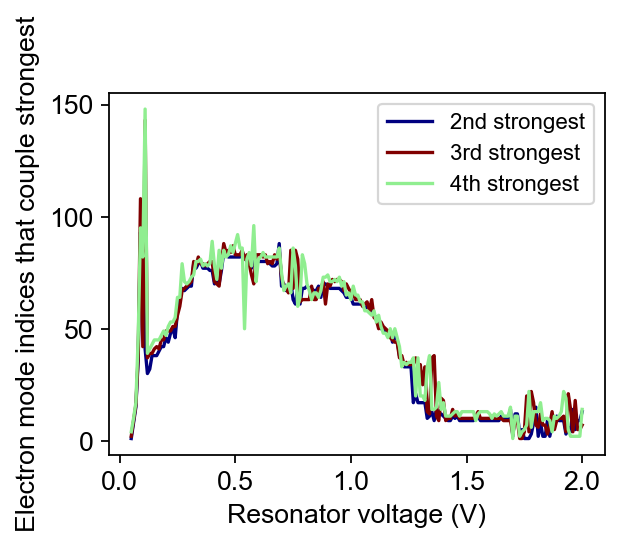

In [135]:
# This plot shows the cavity mode frequency as function of resonator voltage.
# On top of that it shows the frequency of the mode that couples the strongest to the cavity
f_01 = [np.sqrt(Eigenvalues[k, ten_strongest_mode_numbers[k, -1]]) / (2 * np.pi * 1E9) for k in range(len(Vres))]
f_02 = [np.sqrt(Eigenvalues[k, ten_strongest_mode_numbers[k, -2]]) / (2 * np.pi * 1E9) for k in range(len(Vres))]
f_03 = [np.sqrt(Eigenvalues[k, ten_strongest_mode_numbers[k, -3]]) / (2 * np.pi * 1E9) for k in range(len(Vres))]

fig5 = plt.figure(figsize=(4., 3.))
plt.title("Frequency of modes that couple strongest")
plt.plot(Vres, f_01, 'o', label="cavity", **common.plot_opt('cyan', msize=4))
plt.plot(Vres, f_02, 'o', label="2nd strongest", **common.plot_opt('navy', msize=4))
plt.plot(Vres, f_03, 'o', label="3rd strongest", **common.plot_opt('maroon', msize=4))
plt.ylabel("Frequency of modes that couple strongest (GHz)")
plt.xlabel("Resonator voltage (V)")
plt.legend(loc=0, prop={"size": 10})

plt.figure(figsize=(4., 3.))
plt.plot(Vres, ten_strongest_mode_numbers[:, -2], color='navy', label='2nd strongest')
plt.plot(Vres, ten_strongest_mode_numbers[:, -3], color='maroon', label='3rd strongest')
plt.plot(Vres, ten_strongest_mode_numbers[:, -4], color='lightgreen', label='4th strongest')
plt.ylabel("Electron mode indices that couple strongest")
plt.xlabel("Resonator voltage (V)")
plt.legend(loc=0, prop={"size": 10})

r = get_resonator_constants()
delta_f = np.array(cavity_f) - r['f0']
scaled_cavity_frequency = r['f0'] + delta_f * r['l'] / box_y_length

print("The resonator is %.0f um long, which is %.1f box lengths"%(r['l'] * 1E6, r['l'] / box_y_length))
print("On the resonator there are %d electrons" % (N_electrons * r['l'] / box_y_length))

[ 6.41618514  0.03268374  0.09081894]
At the center, the E-field is 3.43e+05 V/m
The curvature at the center of the channel is 1.20e+11 m^-2
(-2.0, 2.0)


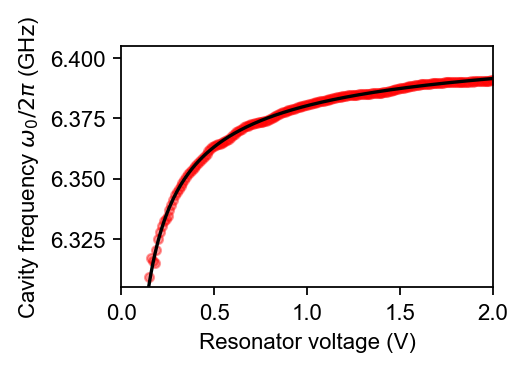

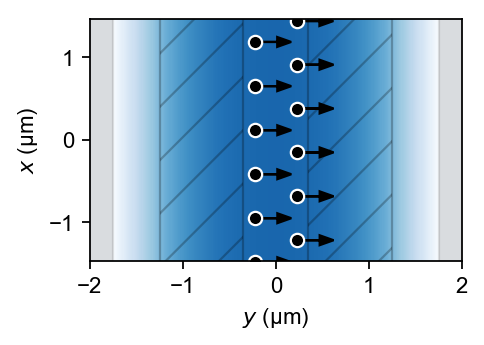

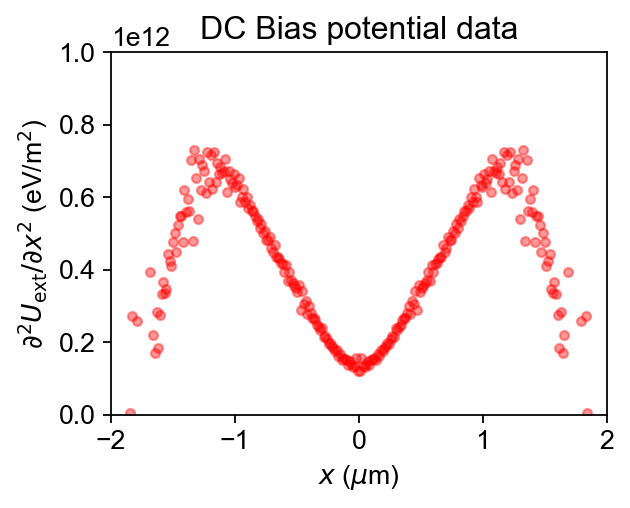

In [138]:
import matplotlib 

# Here we plot the scaled cavity frequency shift vs. the resonator voltage.
fig6 = plt.figure(figsize=(3., 2.))
common.configure_axes(10)
plt.plot(Vres, scaled_cavity_frequency / 1E9, 'o', **common.plot_opt('red', msize=4))
plt.ylabel("Cavity frequency $\omega_0/2\pi$ (GHz)")
plt.xlabel("Resonator voltage (V)")
plt.ylim(r['f0']/1E9 - 0.10, r['f0']/1E9)
plt.xlim(0, 2)

def fitfun(x, *p):
    [a, b, c] = p
    ret = a - b / (np.sqrt(x) - c)
    ret[np.isnan(ret)] = 0
    return ret

fr, ferr = kfit.fitbetter(Vres[np.argsort(Vres)], scaled_cavity_frequency[np.argsort(Vres)] / 1E9, fitfunc=fitfun, 
                          fitparams=[6.40, 0.015, 0.25], domain=(0.10, 2.0))
print(fr)

plt.plot(Vres, fitfun(Vres, *fr), '-k')
# plt.plot(Vres, 6.40 - 0.015 / (1.0*np.sqrt(Vres)-0.25), '-k')

xplot = np.linspace(-3E-6, 3E-6, 501)
yplot = np.linspace(-box_y_length / 2, box_y_length / 2, 11)
Xplot, Yplot = np.meshgrid(xplot, yplot)

RS = anneal.ResonatorSolver(x_symmetric * 1E-6, -Voi * Uinterp_symmetric, efield_data=Uinterp[0])

for l, kk in enumerate([-1]): #([-1, -2, -3]):
    # Here we plot the potential landscape and the electron positions at the voltage point of interest
    fig7 = plt.figure(figsize=(3., 2.))
    plt.pcolormesh(xplot * 1E6, yplot * 1E6, RS.V(Xplot, Yplot), cmap=plt.cm.Blues_r, 
                   vmin=-Voi * 0.8, vmax=-0.025, rasterized=True)
    
#     plt.fill_between([-1.25, -0.35], 1e6 * np.array([box_y_length / 2, box_y_length / 2]), 
#                     y2 = -1e6 * np.array([box_y_length / 2, box_y_length / 2]), color='gray', alpha=0.5)
#     plt.fill_between([1.25, 0.35], 1e6 * np.array([box_y_length / 2, box_y_length / 2]), 
#                     y2 = -1e6 * np.array([box_y_length / 2, box_y_length / 2]), color='gray', alpha=0.5)
    
    plt.gca().add_patch(matplotlib.patches.Polygon([[-1.25, -box_y_length*1e6/2.], [-1.25, box_y_length*1e6/2.], 
                                                    [-0.35, box_y_length*1e6/2.], [-0.35, -box_y_length*1e6/2.]], 
                                                   closed=True, fill=False, hatch='/', alpha=0.25))
    plt.gca().add_patch(matplotlib.patches.Polygon([[1.25, -box_y_length*1e6/2.], [1.25, box_y_length*1e6/2.], 
                                                    [0.35, box_y_length*1e6/2.], [0.35, -box_y_length*1e6/2.]], 
                                                   closed=True, fill=False, hatch='/', alpha=0.25))
    
    plt.fill_between([1.75, 3], 1e6 * np.array([box_y_length / 2, box_y_length / 2]), 
                    y2 = -1e6 * np.array([box_y_length / 2, box_y_length / 2]), color='gray', alpha=0.25)
    plt.fill_between([-1.75, -3], 1e6 * np.array([box_y_length / 2, box_y_length / 2]), 
                    y2 = -1e6 * np.array([box_y_length / 2, box_y_length / 2]), color='gray', alpha=0.25)
    plt.plot(electron_positions[Voi_idx, ::2] * 1E6, electron_positions[Voi_idx, 1::2] * 1E6, 
             'o', color='k', mec='white', mew=1) #color=common.rgb(l, 3))
#     plt.vlines([-1.75, 1.75], 1e6 * np.array([-box_y_length / 2, -box_y_length / 2]), 
#                ymax= 1e6 * np.array([box_y_length / 2, box_y_length / 2]))
    
    

    if two_rows:
        print("There are %d electrons in the left row and %d electrons in the right row." % \
              (len(sorted_left_idxs), len(sorted_right_idxs)))
        plt.plot(electron_positions[Voi_idx, 2 * right_idxs] * 1E6, electron_positions[Voi_idx, 2 * right_idxs + 1] * 1E6,
                 'o', color='yellow')
        plt.plot(electron_positions[Voi_idx, 2 * left_idxs] * 1E6, electron_positions[Voi_idx, 2 * left_idxs + 1] * 1E6,
                 'o', color='lightgreen')

    ax = plt.gca()
    for k in range(np.int(len(electron_positions[Voi_idx, :]) / 2)):
        mode_nr = ten_strongest_mode_numbers[Voi_idx, kk]
        amp = Eigenvectors[k, mode_nr, Voi_idx]
        x_p = electron_positions[Voi_idx, 2 * k] * 1E6
        y_p = electron_positions[Voi_idx, 2 * k + 1] * 1E6

        ax.arrow(x_p, y_p, amp * 3, 0, head_width=0.12, head_length=0.15, fc='k', ec='k')

    plt.xlabel("$y$ (%sm)"%(chr(956)))
    plt.ylabel("$x$ (%sm)"%(chr(956)))
    plt.xlim(-2.0, 2.0)
    plt.ylim(-2.0*2/3.*1.1, 2.0*2/3.*1.1)
#     plt.gca().set_aspect('equal')
#     plt.title("Electron motion of mode %d \n at V = %.2f V"%(mode_nr, Voi))

RS = anneal.ResonatorSolver(x_symmetric * 1E-6, -Uinterp_symmetric, efield_data=Uinterp[0])
print("At the center, the E-field is %.2e V/m" % RS.Ex(0.0E-6, 0.0E-6))
print("The curvature at the center of the channel is %.2e m^-2" % RS.ddVdx(0.0E-6, 0.0E-6))

if 1:
    fig7.savefig(os.path.join(r"S:\Gerwin\Thesis\Figures\ch2", "ReservoirElectronsA.pdf"), 
                 pad_inches=0, bbox_inches='tight', dpi=300)

print(plt.xlim())
    
fig8 = plt.figure(figsize=(4., 3.))
common.configure_axes(12)
plt.plot(x_symmetric, RS.ddVdx(x_symmetric * 1E-6, None), 'o', **common.plot_opt('red', msize=4))
plt.ylim(0, 1E12)
plt.xlim(-2, 2)
plt.ylabel(r"$\partial^2 U_{\mathrm{ext}} / \partial x^2$ (eV/m$^2$)")
plt.xlabel("$x$ ($\mu$m)")
plt.title("DC Bias potential data")

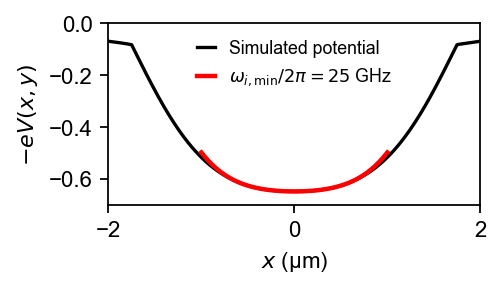

In [117]:
fig1 = plt.figure(figsize=(3., 1.5))
common.configure_axes(10)
plt.plot(x_symmetric, -Uinterp_symmetric, '-k', label="Simulated potential")
plt.ylim(-0.7, 0.00)
plt.xlim(-2, 2)
plt.ylabel("$-eV(x,y)$")
plt.xlabel("$x$ (%sm)"%(chr(956)))

fr, ferr = kfit.fit_poly(x_symmetric, -Uinterp_symmetric, mode='even', fitparams=[0, 1, 2], domain=(-0.5, 0.5), verbose=False)
trap_freq_ghz = 1/ (2 * np.pi * 1e9) * np.sqrt(2 * 1.602E-19 * fr[1] * 1E12 / 9.11E-31)

xplot = np.linspace(-1, 1)
plt.plot(xplot, kfit.polyfunc_even(xplot, *fr), '-r', lw=2, label="$\omega_{i, \mathrm{min}}/2\pi = %.0f$ GHz"%(trap_freq_ghz))

plt.legend(frameon=False, loc=0, handlelength=1, fontsize=8)
# plt.title("DC Bias potential data")
plt.xticks([-2, 0, 2])

if 1:
    fig1.savefig(os.path.join(r"S:\Gerwin\Thesis\Figures\ch2", "ReservoirElectronsC.pdf"), 
                 pad_inches=0, bbox_inches='tight', dpi=300)

In [118]:
save_path = r"S:\Gerwin\Electron on helium\Electron optimization\Realistic potential\Resonator"
sub_dir = r"190607_112207_M018V6_resonator_Vsweep_120_electrons"

print("Loading from %s..."%sub_dir)

with h5py.File(os.path.join(os.path.join(save_path, sub_dir), "Results.h5"), "r") as f:
    k = 0
    converged = list()

    for step in tqdm(f.keys()):
        if "step" in step:
            electron_ri = f[step + "/electron_final_coordinates"][()]

            if k == 0:
                electron_positions = electron_ri
            else:
                electron_positions = np.vstack((electron_positions, electron_ri))

            converged.append(f[step + "/solution_converged"][()])
            k += 1

    Vres = f["Vres"][()]

Loading from 190607_112207_M018V6_resonator_Vsweep_120_electrons...


100%|██████████| 196/196 [00:00<00:00, 336.16it/s]


In [119]:
Nbins = 100
binz = np.linspace(-.75e-6, .75e-6, Nbins+1)
twod_histogram = np.zeros([Nbins, np.shape(electron_positions)[0]])
for k, v in enumerate(Vres[::-1]):
    twod_histogram[:, k] = np.histogram(electron_positions[k, ::2], bins=binz)[0]
    x = np.histogram(electron_positions[k, ::2], bins=Nbins)[1]

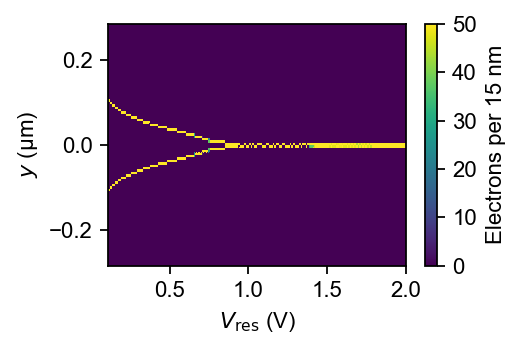

In [123]:
fig9 = plt.figure(figsize=(3., 2.))
common.configure_axes(10)
plt.pcolormesh(Vres, x*1E6, twod_histogram, cmap=plt.cm.viridis, rasterized=True, vmin=0, vmax=50)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Electrons per 15 nm")
plt.ylabel("$y$ (%sm)" % (chr(956)))
plt.xlabel("$V_\mathrm{res}$ (V)")
# plt.xticks([0.5, 1.0, 1.5, 2.0])

if 1:
    fig9.savefig(os.path.join(r"S:\Gerwin\Thesis\Figures\ch2", "ReservoirElectronsB.pdf"), 
                 pad_inches=0, bbox_inches='tight', dpi=300)

In [124]:
save_path = r"S:\Gerwin\Electron on helium\Electron optimization\Realistic potential\Resonator"
sub_dir = r"190607_100554_M018V6_resonator_Vsweep_600_electrons"

print("Loading from %s..."%sub_dir)

with h5py.File(os.path.join(os.path.join(save_path, sub_dir), "Results.h5"), "r") as f:
    k = 0
    converged = list()

    for step in tqdm(f.keys()):
        if "step" in step:
            electron_ri = f[step + "/electron_final_coordinates"][()]

            if k == 0:
                electron_positions = electron_ri
            else:
                electron_positions = np.vstack((electron_positions, electron_ri))

            converged.append(f[step + "/solution_converged"][()])
            k += 1

    Vres = f["Vres"][()]

Loading from 190607_100554_M018V6_resonator_Vsweep_600_electrons...


100%|██████████| 196/196 [00:01<00:00, 148.17it/s]


In [125]:
Nbins = 100
binz = np.linspace(-.75e-6, .75e-6, Nbins+1)
twod_histogram = np.zeros([Nbins, np.shape(electron_positions)[0]])
for k, v in enumerate(Vres[::-1]):
    twod_histogram[:, k] = np.histogram(electron_positions[k, ::2], bins=binz)[0]
    x = np.histogram(electron_positions[k, ::2], bins=Nbins)[1]

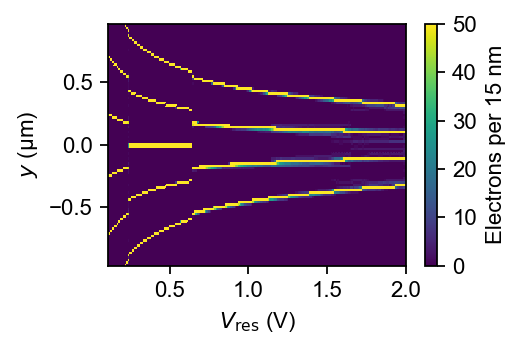

In [126]:
fig9 = plt.figure(figsize=(3., 2.))
common.configure_axes(10)
plt.pcolormesh(Vres, x*1E6, twod_histogram, cmap=plt.cm.viridis, rasterized=True, vmin=0, vmax=50)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Electrons per 15 nm")
plt.ylabel("$y$ (%sm)" % (chr(956)))
plt.xlabel("$V_\mathrm{res}$ (V)")
# plt.xticks([0.5, 1.0, 1.5, 2.0])

if 1:
    fig9.savefig(os.path.join(r"S:\Gerwin\Thesis\Figures\ch2", "ReservoirElectronsD.pdf"), 
                 pad_inches=0, bbox_inches='tight', dpi=300)